# 09-03 영어-한국어 Word2Vec 실습


출처: https://wikidocs.net/50739

gensim 패키지에서 제공하는 이미 구현된 Word2Vec을 사용하여 영어와 한국어 데이터를 학습합니다.


## 1. 영어 Word2Vec 만들기

파이썬의 gensim 패키지에는 Word2Vec을 지원


gensim 패키지를 이용하면 손쉽게 단어를 임베딩 벡터로 변환 가능
 
-> 영어로 된 코퍼스를 다운받아 전처리를 수행 -> 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행



In [10]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

### 1) 훈련 데이터 이해하기

훈련 데이터를 다운로드 합니다.



In [11]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x2499e81d460>)

훈련 데이터 파일은 xml 문법으로 작성되어 있어 자연어를 얻기 위해서는 전처리가 필요

얻고자 하는 실질적 데이터는 영어문장으로만 구성된 내용을 담고 있는 <content>와 </content> 사이의 내용

전처리 작업을 통해 xml 문법들은 제거하고, 해당 데이터만 가져와야 합니다.

----------------


<content>와 </content> 사이의 내용 중에는 (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어도 등장하는데 이 또한 제거해야 함

<file id="1">
  <head>
<url>http://www.ted.com/talks/knut_haanaes_two_reasons_companies_fail_and_how_to_avoid_them</url>
       <pagesize>72832</pagesize>
... xml 문법 중략 ...
<content>
Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities:
... content 내용 중략 ...
To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.
(Laughter)
... content 내용 중략 ...
(Applause)
</content>
</file>
<file id="2">
    <head>
<url>http://www.ted.com/talks/lisa_nip_how_humans_could_evolve_to_survive_in_space<url>
... 이하 중략 ...
    
----------------
    
### 2) 훈련 데이터 전처리하기


In [12]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [9]:

import gensim
gensim.__version__

'4.3.0'

In [16]:
nltk.__version__

'3.8.1'

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\USER/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

# https://github.com/nltk/nltk/issues/2927  문제가 동일하게 발생
# 3일 고생, punkt파일을 직접 다운받아서 압축풀고 곳곳에 복붙하고, nltk 3.8.1 version 설치하니 진행됨.
# 참고로 구글 코랩도 3.7 버젼 - 하니 3초만에 실행이 안됨. 아마도... nltk version문제가 큰것으로 추측됨
# Anaconda prompt에서 했던 명령어 pip install -U nltk

In [15]:
print('총 샘플의 개수 : {}'.format(len(result)))


총 샘플의 개수 : 273424


In [17]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)
    
# 상위 3개 문장만 출력해보았는데 토큰화가 수행되었음을 볼 수 있습니다. Word2Vec 모델에 텍스트 데이터를 훈련시킵니다.



['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


###  3) Word2Vec 훈련시키기


In [19]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

Word2Vec의 하이퍼파라미터값은 다음과 같습니다.

size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
window = 컨텍스트 윈도우 크기
min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
workers = 학습을 위한 프로세스 수
sg = 0은 CBOW, 1은 Skip-gram.

Word2Vec에 대해서 학습을 진행하였습니다. Word2Vec는 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원합니다. man과 가장 유사한 단어들은 어떤 단어들일까요?

In [20]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8354935646057129), ('guy', 0.8081638216972351), ('lady', 0.7612051367759705), ('boy', 0.7571767568588257), ('girl', 0.743209719657898), ('soldier', 0.7201828360557556), ('gentleman', 0.7201477885246277), ('poet', 0.6847690343856812), ('kid', 0.6804652810096741), ('son', 0.6551137566566467)]


man과 유사한 단어로 woman, guy, boy, lady, girl, gentleman, soldier, kid 등을 출력하는 것을 볼 수 있습니다. Word2Vec를 통해 단어의 유사도를 계산할 수 있게 되었습니다.

## 4) Word2Vec 모델 저장하고 로드하기

공들여 학습한 모델을 언제든 나중에 다시 사용할 수 있도록 컴퓨터 파일로 저장하고 다시 로드해보겠습니다. 이 모델을 가지고 향후 시각화를 진행할 예정이므로 꼭 저장해주세요.


In [21]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [23]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8354935646057129), ('guy', 0.8081638216972351), ('lady', 0.7612051367759705), ('boy', 0.7571767568588257), ('girl', 0.743209719657898), ('soldier', 0.7201828360557556), ('gentleman', 0.7201477885246277), ('poet', 0.6847690343856812), ('kid', 0.6804652810096741), ('son', 0.6551137566566467)]


## 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)

네이버 영화 리뷰 데이터로 한국어 Word2Vec을 만들어봅시다.



In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [25]:
# 네이버 영화 리뷰 데이터를 다운로드합니다.


urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")


('ratings.txt', <http.client.HTTPMessage at 0x2499e81d220>)

In [26]:
train_data = pd.read_table('ratings.txt')


In [27]:
train_data[:5] # 상위 5개 출력


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [28]:
print(len(train_data)) # 리뷰 개수 출력


200000


In [29]:
# NULL 값 존재 유무 - 20만개의 샘플 중 결측값 유무

print(train_data.isnull().values.any())


True


In [30]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [31]:
print(len(train_data)) # 리뷰 개수 출력


199992


In [32]:
# 총 199,992개의 리뷰가 존재합니다. 정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행합니다.

# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\USER\AppData\Local\Temp\ipykernel_11860\1452899067.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거하겠습니다. 형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행합니다. 다소 시간이 소요될 수 있습니다.

In [33]:
!pip install tqdm

In [34]:
from tqdm import tqdm

In [35]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [12:29<00:00, 266.85it/s]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


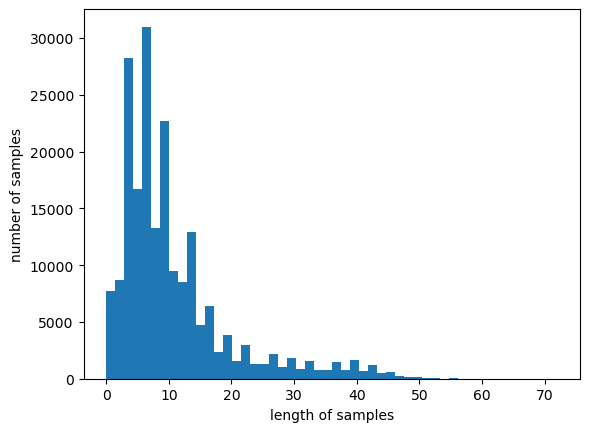

In [36]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습합니다.



In [37]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [38]:
# 학습이 다 되었다면 Word2Vec 임베딩 행렬의 크기를 확인합니다.

# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [39]:
# 총 16,477개의 단어가 존재하며 각 단어는 100차원으로 구성되어져 있습니다. '최민식'과 유사한 단어들을 뽑아봅시다.

print(model.wv.most_similar("최민식"))


[('서영희', 0.8442935347557068), ('안성기', 0.8405871987342834), ('한석규', 0.8333979845046997), ('스트립', 0.8240647912025452), ('맷', 0.8168047070503235), ('라인업', 0.8166216611862183), ('채민서', 0.8154826164245605), ('오광록', 0.8150193691253662), ('이정재', 0.8141971230506897), ('최민수', 0.8088560700416565)]


In [40]:
print(model.wv.most_similar("히어로"))


[('호러', 0.8542080521583557), ('느와르', 0.8412086963653564), ('무협', 0.8291923999786377), ('물의', 0.827262818813324), ('슬래셔', 0.8250893950462341), ('블랙', 0.8120337724685669), ('무비', 0.7982679009437561), ('정통', 0.7978744506835938), ('물', 0.7921004295349121), ('블록버스터', 0.7839065790176392)]


# 3. 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

자연어 처리 작업을 할때, 케라스의 Embedding()를 사용하여 갖고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만, 위키피디아 등의 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용

예 )  감성 분류 작업을 하는데 훈련 데이터의 양이 부족한 상황

->  다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 이용

사전 훈련된 워드 임베딩을 가져와서 간단히 단어들의 유사도를 구해보는 실습

구글은 사전 훈련된 3백만 개의 Word2Vec 단어 벡터들을 제공

각 임베딩 벡터의 차원은 300


In [41]:
import gensim
import urllib.request

# # 구글의 사전 훈련된 Word2Vec 모델을 로드.
# urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
#                            filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [42]:
print(word2vec_model.vectors.shape)
# 모델의 크기

(3000000, 300)


In [43]:
# 모델의 크기는 3,000,000 x 300입니다. 
# 즉, 3백만 개의 단어와 각 단어의 차원은 300입니다. 파일의 크기가 3기가가 넘는 이유를 계산해보면 아래와 같습니다.

# 3 million words * 300 features * 4bytes/feature = ~3.35GB

print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

0.40797037
0.057204388


In [44]:
# 단어 'book'의 벡터를 출력해봅시다.

print(word2vec_model['book'])



[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

참고 : Word2vec 모델은 자연어 처리에서 단어를 밀집 벡터로 만들어주는 단어 임베딩 방법론이지만 최근에 들어서는 자연어 처리를 넘어서 추천 시스템에도 사용되고 있는 모델